CVAT markup to YOLO

# Libraries

In [45]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tqdm import tqdm
from bs4 import BeautifulSoup as bs

# Data reading and transforming to YOLO

In [46]:
name = 'new_tid_ver2'

In [47]:
dict_labels = {'tid_old': '0', 'tid_new': '1'}

In [48]:
with open(f'annotations/annotations_{name}.xml', 'r', encoding='utf-8') as f:
    data = f.read()
bs_data = bs(data, "xml")
filenames, widths, heights = [], [], []
xtls, ytls, xbrs, ybrs, rotations = [], [], [], [], []
class_ids = []
for image_data in bs_data.find_all('image'):
    filenames.append(image_data['name'])
    widths.append(image_data['width'])
    heights.append(image_data['height'])
    box_data = image_data.find_all('box')[0]
    xtls.append(box_data['xtl']); ytls.append(box_data['ytl'])
    xbrs.append(box_data['xbr']); ybrs.append(box_data['ybr'])
    class_ids.append(box_data['label'])
    try: rotations.append(box_data['rotation'])
    except KeyError: rotations.append(0)

In [49]:
def get_dots(dots):
    dot_1 = dots[0]; dot_3 = dots[1]
    dot_2 = dots[2]; dot_4 = dots[3]
    return dot_1, dot_2, dot_3, dot_4

In [50]:
x1s, y1s, x2s, y2s, x3s, y3s, x4s, y4s = [], [], [], [], [], [], [], []
indexes_to_delete = [] 
for i in tqdm(range(len(ytls))):
    xtl, xbr, ytl, ybr, rotation = (float(xtls[i]), float(xbrs[i]), 
                                    float(ytls[i]), float(ybrs[i]), 
                                    float(rotations[i]))
    center_x = (xtl + xbr) / 2; center_y = (ytl + ybr) / 2
    rect = patches.Rectangle(
        (xtl, ytl), xbr - xtl, ybr - ytl, angle=rotation, 
        rotation_point=(center_x, center_y))
    
    dots = rect.get_corners()
    dot_1, dot_2, dot_3, dot_4 = get_dots(dots)    
    x1, y1 = dot_1; x2, y2 = dot_2
    x3, y3 = dot_3; x4, y4 = dot_4
    
    image_filename = f'images/{name}/{filenames[i]}'
    img = ImageOps.exif_transpose(Image.open(image_filename))
    x1s.append(x1); y1s.append(y1)
    x2s.append(x2); y2s.append(y2)
    x3s.append(x3); y3s.append(y3)
    x4s.append(x4); y4s.append(y4)

100%|██████████| 288/288 [00:05<00:00, 49.52it/s]


In [51]:
len(x1s), len(x2s), len(x3s), len(x4s), len(y1s), len(y2s), len(y3s), len(y4s),\
len(filenames), len(widths), len(heights), len(class_ids)

(288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288)

In [52]:
df_cvat = pd.DataFrame({
    'filename': filenames, 'class_id': class_ids,
    'width': widths, 'height': heights,
    'x1': x1s, 'y1': y1s, 'x2': x2s, 'y2': y2s,
    'x3': x3s, 'y3': y3s, 'x4': x4s, 'y4': y4s})
x_columns = [x for x in df_cvat.columns if 'x' in x]
y_columns = [y for y in df_cvat.columns if 'y' in y]
df_normalized = df_cvat.copy()
df_normalized[x_columns] = df_cvat[x_columns].div(
    df_cvat['width'].astype(float), axis=0)
df_normalized[y_columns] = df_cvat[y_columns].div(
    df_cvat['height'].astype(float), axis=0)
df_normalized.head()

,filename,class_id,width,height,x1,y1,x2,y2,x3,y3,x4,y4
0,0.jpg,tid_new,960,1280,0.361865,0.645312,0.482917,0.664531,0.482917,0.645312,0.361865,0.664531
1,1.jpg,tid_new,1560,2080,0.424851,0.469666,0.491989,0.476786,0.490902,0.465941,0.425938,0.480511
2,10.jpg,tid_new,1170,1560,0.521670,0.453255,0.576697,0.441584,0.568753,0.431785,0.529614,0.463054
3,100.jpg,tid_new,1560,2080,0.390769,0.616010,0.463846,0.627740,0.463846,0.616010,0.390769,0.627740
4,101.jpg,tid_new,1560,2080,0.342837,0.564368,0.418509,0.574608,0.418276,0.563479,0.343070,0.575497


# Normalized data to .txt

In [53]:
path_txts = Path(f'yolo_markup/{name}')
if not os.path.exists(path_txts): os.makedirs(path_txts)

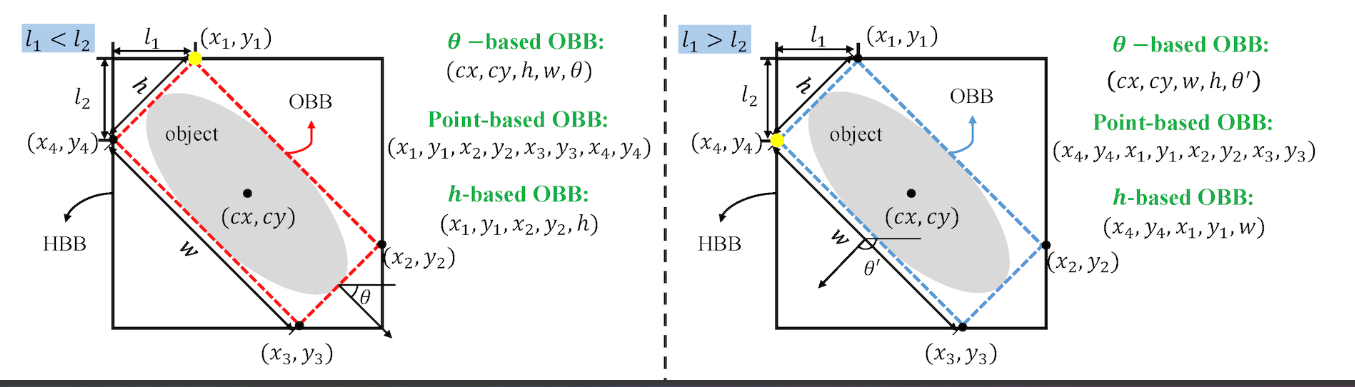

In [54]:
for row in df_normalized.iterrows():
    row = row[1]
    str_to_write = f'{dict_labels[row["class_id"]]} {row["x1"]} {row["y1"]} {row["x2"]} {row["y2"]} {row["x3"]} {row["y3"]} {row["x4"]} {row["y4"]}'
    with open(path_txts / (row['filename'].split('.')[0]+'.txt'), 'w') as file:
        file.write(str_to_write)